In [13]:
import torch
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
#from collections import defaultdict, deque

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        image2 = torch.clone(image)
        if len(image2.shape) == 4:
            # batched
            image2 = image2.permute(1, 0, 2, 3)
        for t, m, s in zip(image2, self.mean, self.std):
            t.mul_(s).add_(m)
        return image2.permute(1, 0, 2, 3)
    
norm = v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
unnorm = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

class TorchPCA(object):

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        self.mean_ = X.mean(dim=0)
        unbiased = X - self.mean_.unsqueeze(0)
        U, S, V = torch.pca_lowrank(unbiased, q=self.n_components, center=False, niter=4)
        self.components_ = V.T
        self.singular_values_ = S
        return self

    def transform(self, X):
        t0 = X - self.mean_.unsqueeze(0)
        projected = t0 @ self.components_.T
        return projected


def pca(image_feats_list, dim=3, fit_pca=None, max_samples=None):
    device = image_feats_list[0].device

    def flatten(tensor, target_size=None):
        if target_size is not None and fit_pca is None:
            tensor = F.interpolate(tensor, (target_size, target_size), mode="bilinear")
        B, C, H, W = tensor.shape
        return tensor.permute(1, 0, 2, 3).reshape(C, B * H * W).permute(1, 0).detach().cpu()

    if len(image_feats_list) > 1 and fit_pca is None:
        target_size = image_feats_list[0].shape[2]
    else:
        target_size = None

    flattened_feats = []
    for feats in image_feats_list:
        flattened_feats.append(flatten(feats, target_size))
    x = torch.cat(flattened_feats, dim=0)

    # Subsample the data if max_samples is set and the number of samples exceeds max_samples
    if max_samples is not None and x.shape[0] > max_samples:
        indices = torch.randperm(x.shape[0])[:max_samples]
        x = x[indices]

    if fit_pca is None:
        fit_pca = TorchPCA(n_components=dim).fit(x)

    reduced_feats = []
    for feats in image_feats_list:
        x_red = fit_pca.transform(flatten(feats))
        if isinstance(x_red, np.ndarray):
            x_red = torch.from_numpy(x_red)
        x_red -= x_red.min(dim=0, keepdim=True).values
        x_red /= x_red.max(dim=0, keepdim=True).values
        B, C, H, W = feats.shape
        reduced_feats.append(x_red.reshape(B, H, W, dim).permute(0, 3, 1, 2).to(device))

    return reduced_feats, fit_pca

from pytorch_lightning import seed_everything

def _remove_axes(ax):
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xticks([])
    ax.set_yticks([])


def remove_axes(axes):
    if len(axes.shape) == 2:
        for ax1 in axes:
            for ax in ax1:
                _remove_axes(ax)
    else:
        for ax in axes:
            _remove_axes(ax)

def plot_feats(image, lr, hr):
    assert len(image.shape) == len(lr.shape) == len(hr.shape) == 3
    seed_everything(0)
    [lr_feats_pca, hr_feats_pca], _ = pca([lr.unsqueeze(0), hr.unsqueeze(0)])
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image.permute(1,2,0).detach().cpu())
    ax[0].set_title("Image")
    ax[1].imshow(lr_feats_pca[0].permute(1,2,0).detach().cpu())
    ax[1].set_title("Original Features")
    ax[2].imshow(hr_feats_pca[0].permute(1,2,0).detach().cpu())
    ax[2].set_title("Upsampled Features")
    remove_axes(ax)
    plt.show()

In [14]:
input_size = 224
image_path = "/data/NWPU-RESISC45/airplane/airplane_301.jpg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_norm = True

transform = v2.Compose([
    v2.Resize(input_size),
    v2.CenterCrop((input_size, input_size)),
    v2.ToTensor(),
    norm
])

image_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

Using cache found in /d/pfournie/.cache/torch/hub/facebookresearch_dinov2_main
Global seed set to 0


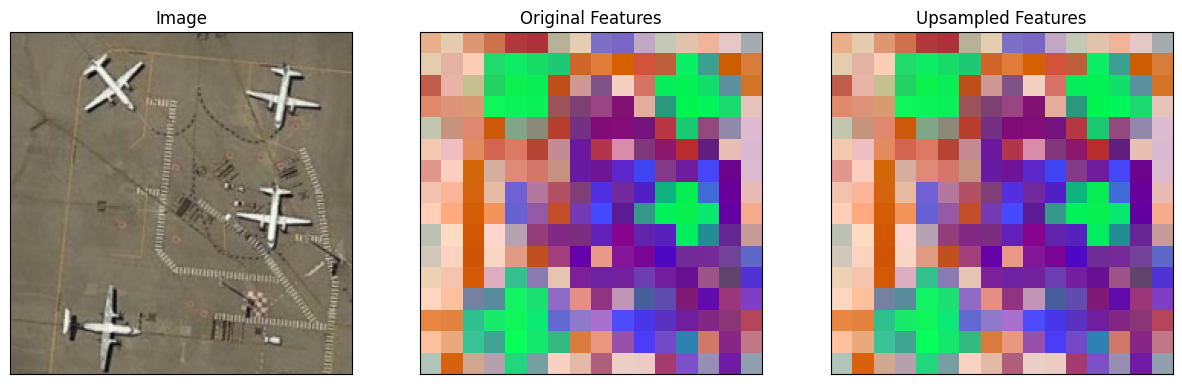

In [15]:
import numpy as np
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
h = image_tensor.shape[2] // 14
w = image_tensor.shape[3] // 14
lr_feats = model.forward_features(image_tensor)["x_norm_patchtokens"].reshape(-1, h, w, 384).permute(0, 3, 1, 2)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], lr_feats[0])